# Image similarity model


In [1]:
from tensorflow.keras.layers import Flatten, Dense, Input,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow as tf
import cv2
from scipy.spatial import distance
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import VGG16 model from Tensorflow

In [2]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True, pooling='max', input_shape=(224, 224, 3))

In [3]:
basemodel = Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)

In [4]:
#basemodel.summary()

### Vectorizer for images

In [5]:
def get_feature_vector(img):
 img1 = cv2.resize(img, (224, 224))
 feature_vector = basemodel.predict(img1.reshape(1, 224, 224, 3))
 return feature_vector

### Calculate similarity function

In [6]:
def calculate_similarity(vector1, vector2):
 return distance.cosine(vector1, vector2)

### Create vectors for all images in local folder

In [7]:
# directory = '/home/beres/code/tklein98/crate_scanner/notebooks/images/'
# vectors = []

# for filename in os.listdir(directory):
#     img = cv2.imread(f'images/{filename}')
#     img1 = get_feature_vector(img)
#     vectors.append([filename, img1.copy()])

### The vector file can be saved and retrieved as follows;

In [ ]:
# The vectors array has been saved to the notebooks folder in the project repo 
# array = np.array(vectors)
# np.save('array', array)

In [ ]:
## Load saved file using the following code; x_loaded = np.load(path/'x.npy')
vectors = np.load('array.npy', allow_pickle = True)

### Import test image and find similar image

In [23]:
img1 = cv2.imread("test_images/Arcade Fire_Funeral_38.jpg")

f1 = get_feature_vector(img1)
comparison = []

for vector in vectors:
    for i in vector[1]:
        comparison.append(calculate_similarity(f1, i))
        

### Retrieve details for closest match

Funeral Arcade Fire.jpg


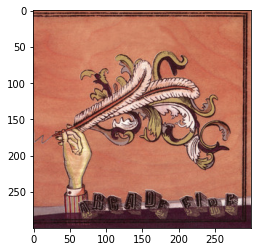

In [25]:
index = comparison.index(min(comparison))
album = vectors[index][0]
print(album)
album = cv2.imread(f'images/{album}')[:,:,::-1]
plt.imshow(album)

### Loop over test images and find matches

In [11]:
directory = '/home/beres/code/tklein98/crate_scanner/notebooks/test_images/subset/'
comparisons = []
import ipdb


for filename in os.listdir(directory):
    img = cv2.imread(f'test_images/subset/{filename}')
    img1 = get_feature_vector(img)
    comparison = {}
    counter = 0
    for vector in vectors:
        for j in vector[1]:
            #ipdb.set_trace()
            if len(comparison) == 0:
                #ipdb.set_trace()
                comparison[filename] = (counter, calculate_similarity(img1, j))
            elif comparison[filename][1] > calculate_similarity(img1, j):
                #ipdb.set_trace()
                comparison[filename] = (counter, calculate_similarity(img1, j))
            counter += 1
    comparisons.append(comparison)


In [12]:
comparisons

[{'Joy Division_Closer_22.jpg': (215, 0.09646731615066528)},
 {'Jeff Buckley_Grace_10.jpg': (288, 0.2165355086326599)},
 {'Coldplay_A Rush Of Blood To The Head_10.jpg': (212, 0.13231706619262695)},
 {'Kendrick Lamar_To Pimp A Butterfly_36.jpg': (299, 0.3215525150299072)},
 {'King Crimson_In The Court Of The Crimson King_9.jpg': (438,
   0.5749334096908569)},
 {'Bob Dylan_Highway 61 Revisited_6.jpg': (330, 0.3879200220108032)},
 {'Joy Division_Unknown Pleasures_9.jpg': (51, 0.3692595958709717)},
 {'Bob Dylan_Blood On The Tracks_4.jpg': (168, 0.2210826873779297)},
 {'Bon Iver_For Emma, Forever Ago_15.jpg': (411, 0.48731136322021484)},
 {'Kendrick Lamar_To Pimp A Butterfly_46.jpg': (357, 0.3525710105895996)},
 {'Fleetwood Mac_Rumours_0.jpg': (297, 0.4570819139480591)},
 {'My Bloody Valentine_Loveless_27.jpg': (176, 0.36452221870422363)},
 {'Coldplay_A Rush Of Blood To The Head_20.jpg': (212, 0.10307073593139648)},
 {'Bon Iver_For Emma, Forever Ago_0.jpg': (316, 0.4547821283340454)},
 {'Ki

In [16]:
vectors[264][0]

'Blonde on Blonde Bob Dylan.jpg'

In [20]:
whitelist = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
cleaned_string = ''.join(filter(whitelist.__contains__, vectors[264][0]))
cleaned_string = cleaned_string[:-3].lower()

cleaned_string

'blondeonblondebobdylan'